### Etape nous permettant d'utiliser Google Colab (Optionnel)

In [7]:
!git clone https://github.com/ThomasLpgs/AI-sport-recognition.git

Clonage dans 'AI-sport-recognition'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
^Cception d'objets:   0% (34/3620), 708.01 Kio | 687.00 Kio/s


In [ ]:
%cd AI-sport-recognition/

### Import des dépendances de FASTAI

In [3]:
from fastai.vision import *
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
torch.cuda.get_device_name(0)

### Chargement de notre dataset

In [3]:
classes = ['baseball', 'basketball', 'football', 'footballamericain', 'golf', 'handball', 'pingpong', 'rugby', 'tennis', 'volleyball']

In [18]:
for c in classes:
    verify_images("sport/train/"+c, delete=True)
    verify_images("sport/test/"+c, delete=True)

In [50]:
data = ImageDataBunch.from_folder(path="sport", train="train", test="test", valid_pct=0.25, ds_tfms=get_transforms(), size=224, bs=32).normalize(imagenet_stats)

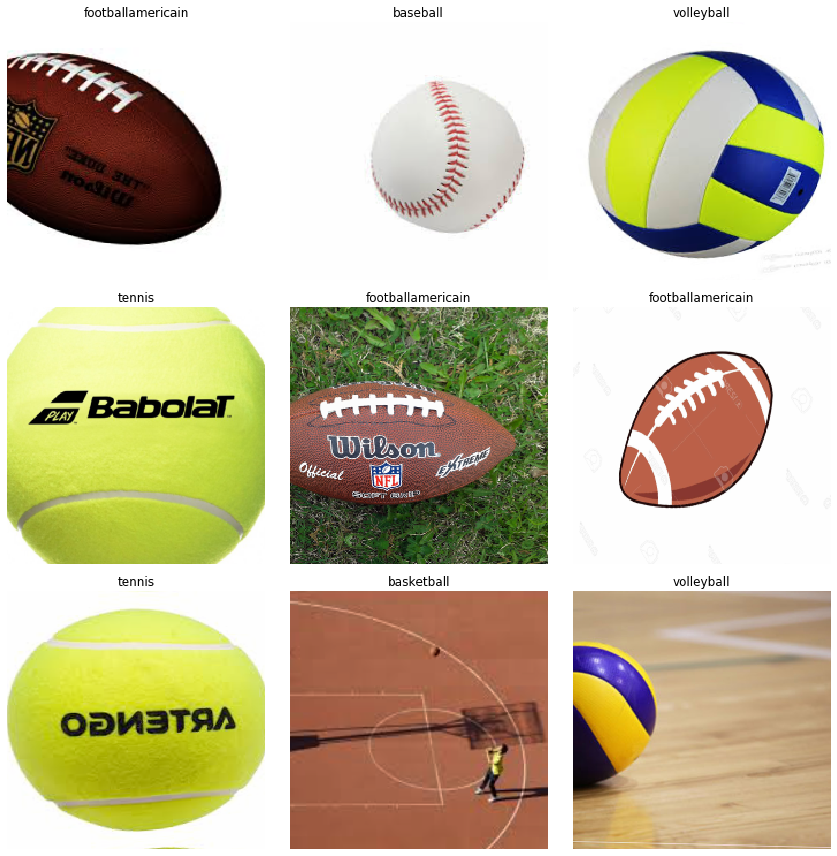

In [5]:
data.show_batch(rows=3)

### Chargement du model

In [51]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

### Recherche du taux d'apprentisage optimal

In [21]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.91E-02
Min loss divided by 10: 3.98E-03


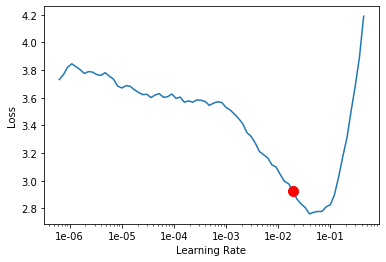

In [22]:
learn.recorder.plot(suggestion=True)

In [ ]:
lr = learn.recorder.min_grad_lr

### Entraînement

In [23]:
# On lance 4 epochs
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.638566,1.226849,0.737303,01:15
1,1.564642,0.940263,0.798599,01:14
2,0.948696,0.584710,0.859895,01:16
3,0.605967,0.556006,0.852890,01:14


In [ ]:
# Puis on lance les epochs un à un tant que le train_loss, le valid_loss baissent et l'accuracy augmente.
learn.fit_one_cycle(1, slice(lr))

# Au bout d'une dizaine d'epoch on obtient une accuracy de 93%

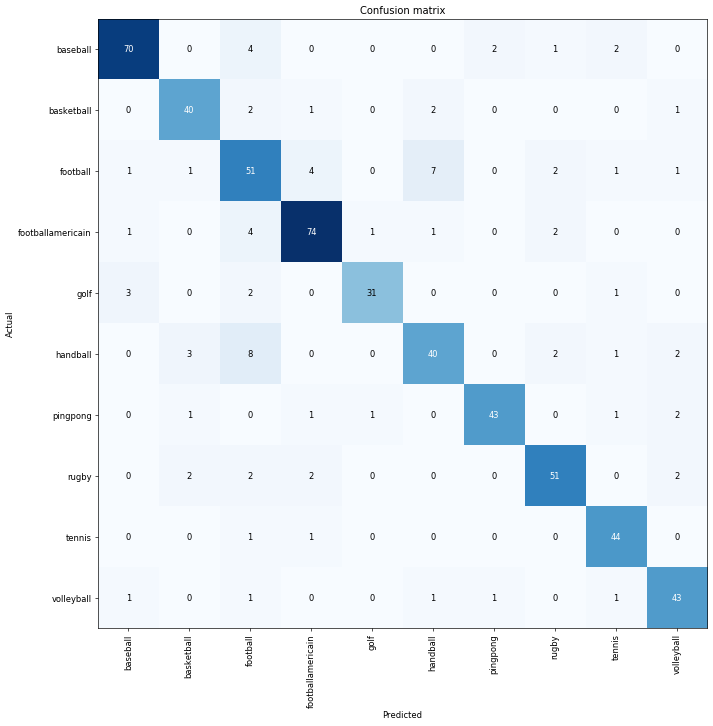

In [47]:
# On regarde la matrice de confusion
preds, y, losses = learn.get_preds(with_loss=True)

interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
# On décide de débloquer les poids prédéfinis sur le model resnet50
learn.unfreeze()

### Recalcul du taux d'apprentisage optimal

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
lr = learn.recorder.min_grad_lr

### Entrainement avec poids 'unfreeze'

In [ ]:
# On lance les epochs un à un tant que le train_loss, le valid_loss baissent et l'accuracy augmente.
learn.fit_one_cycle(1, slice(lr))

# On obtient ici une accuracy de 93,8%

### Sauvegarde de notre modèle

In [ ]:
# On n'utilise pas learn.save() parce que cela créé un fichier plus volumineux (320Mo vs 97Mo)
# qui ne contient pas simplement les poids mais un model complet qui est prêt à être réentrainé
# Nous allons avoir besoin de ce fichier dans le site web
learn.export()

### Chargement de notre modèle

In [4]:
learn = load_learner('sport/')

### Prédiction

In [5]:
# La technique utilisée ici est légèrement différente de celle vue en cours.
# Ici on a l'avantage de ne pas avoir de lien avec l'objet 'data' et on a en plus le détail de la prédiction :
# La prédiction, le score en pourcentage pour chaque catégorie. 
# Ici vous pouvez donc simplement exécuter le chargement des dépendances de FASTAI, le chargement du modèle ci dessus ainsi que cette cellule.
import blah
filename = blah.gui_fname() # <-- Demande de choisir une image
img = open_image(filename)
pred_class, pred_idx, losses = learn.predict(img)
print(pred_class)
print({"prediction": str(pred_class), "scores": sorted(zip(learn.data.classes, map(float, losses)), key=lambda p: p[1], reverse=True)})

football
{'prediction': 'football', 'scores': [('football', 0.6478649973869324), ('rugby', 0.32820460200309753), ('handball', 0.012499137781560421), ('tennis', 0.004330919124186039), ('footballamericain', 0.002568037249147892), ('volleyball', 0.0024001291021704674), ('baseball', 0.0017750534461811185), ('pingpong', 0.000283387751551345), ('golf', 5.2505143685266376e-05), ('basketball', 2.1152258341317065e-05)]}
